Linear Mixed Effects Model.

In [1]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [2]:
tadpoleD1D2File = 'TADPOLE_D1_D2.csv'

data_tadpole_all = pd.read_csv(tadpoleD1D2File, low_memory=False)
data_tadpole=data_tadpole_all[['RID','D1','D2','APOE4',
                       'MMSE','DXCHANGE', 'AGE', 
                       'ADAS13','Ventricles','Hippocampus','ICV_bl','Month_bl', 'Years_bl']].copy()

#Create Diagnosis variable based on DXCHANGE
idx_mci=data_tadpole['DXCHANGE']==4
data_tadpole.loc[idx_mci,'DXCHANGE']=2
idx_ad = data_tadpole['DXCHANGE']==5
data_tadpole.loc[idx_ad,'DXCHANGE']=3
idx_ad = data_tadpole['DXCHANGE']==6
data_tadpole.loc[idx_ad,'DXCHANGE']=3
idx_cn = data_tadpole['DXCHANGE']==7
data_tadpole.loc[idx_cn,'DXCHANGE']=1
idx_mci=data_tadpole['DXCHANGE']==8
data_tadpole.loc[idx_mci,'DXCHANGE']=2
idx_cn = data_tadpole['DXCHANGE']==9
data_tadpole.loc[idx_cn,'DXCHANGE']=1
data_tadpole=data_tadpole.rename(columns={'DXCHANGE':'Diagnosis'})

data_tadpole['Diagnosis'] = data_tadpole.Diagnosis.astype('category')

In [3]:
#correct ventricle volume
data_tadpole['Ventricles_ICV'] = data_tadpole['Ventricles'].values / data_tadpole['ICV_bl'].values

Subjects for prediction

In [5]:
#drop NaN
data_tadpole.dropna(subset = ['RID', 'Diagnosis', 'ICV_bl', 'Ventricles'],how='any',inplace=True)

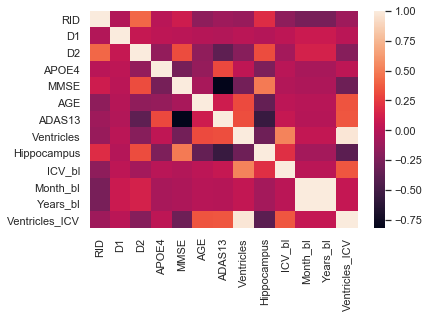

In [6]:
corr = data_tadpole.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

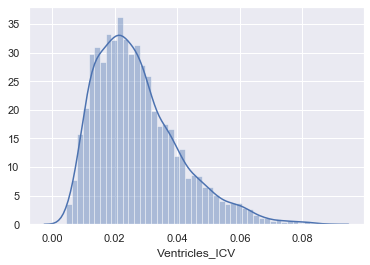

In [7]:
sns.distplot(data_tadpole.Ventricles_ICV)
plt.show()

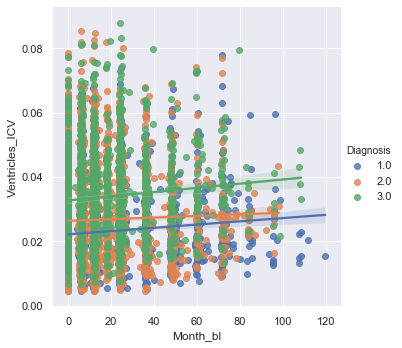

In [8]:
sns.lmplot(x = "Month_bl", y = "Ventricles_ICV", hue="Diagnosis", data = data_tadpole)

In [9]:
#Set Age for each point
data_tadpole['VISITAGE'] = data_tadpole['AGE'] + data_tadpole['Years_bl']

In [10]:
md = sm.MixedLM.from_formula("Ventricles_ICV ~ 1 + Month_bl+VISITAGE", re_formula="~1 + Month_bl", groups="RID", data=data_tadpole)
mdf = md.fit()
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Ventricles_ICV
No. Observations:   6693    Method:             REML          
No. Groups:         1690    Scale:              0.0000        
Min. group size:    1       Log-Likelihood:     27011.7613    
Max. group size:    11      Converged:          No            
Mean group size:    4.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          -0.025    0.002 -15.403 0.000 -0.029 -0.022
Month_bl            0.000    0.000   7.843 0.000  0.000  0.000
VISITAGE            0.001    0.000  31.221 0.000  0.001  0.001
RID Var             0.000    0.000                            
RID x Month_bl Cov  0.000    0.000                            
Month_bl Var        0.000                                     



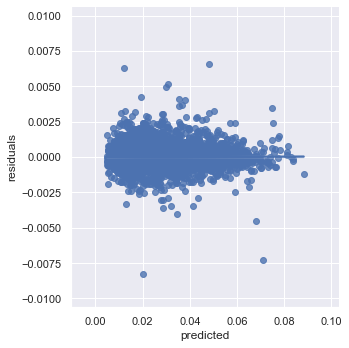

In [11]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["Month_bl"] = data_tadpole.Month_bl
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

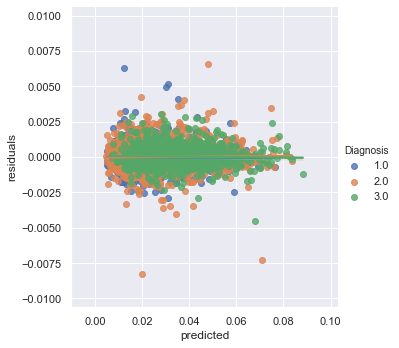

In [20]:
performance["Diagnosis"] = data_tadpole.Diagnosis
sns.lmplot(x = "predicted", y = "residuals", data = performance, hue='Diagnosis')

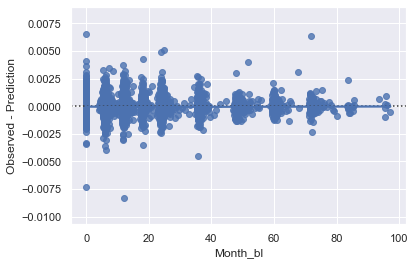

In [12]:
ax = sns.residplot(x = "Month_bl", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [32]:
# and let's store the rmse
y = mdf.resid.values
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).values.mean())

results = pd.DataFrame()
results["Method"] = ["Mixed"]
results["RMSE"] = RMSE
results

,Method,RMSE
0,Mixed,0.030221


In [42]:
md.predict()

TypeError: predict() missing 1 required positional argument: 'params'

In [34]:
D2=data_tadpole['D2'].copy()
#Make list of RIDs in D2 to be predicted
idx_d2=D2==1
data_tadpole_RID = data_tadpole.loc[idx_d2,'RID']
SD2=pd.Series(np.unique(data_tadpole_RID.values))
SD2.to_csv('ToPredict_D2.csv',index=False)

In [35]:
data_d2 = pd.read_csv('ToPredict_D2.csv', low_memory=False)

TypeError: predict() missing 1 required positional argument: 'params'